# Support Vector Machine (SVM): Performance Analysis

This notebook provides a comprehensive analysis of the **Support Vector Machine (SVM)** model performance.

## Model Configuration

- **Model ID**: `5b`
- **Model Type**: `svm`

## Data Sources

- **Metrics**: Dynamically resolved via `get_model_data_path()` (typically `data/stage5/svm/`)
- **Logs**: `logs/stage5/` (dynamically resolved)
- **MLflow**: `mlruns/`

> **Note**: Execute cells sequentially.

## Imports and Configuration

### Standard Library Imports

In [1]:
# Standard library imports
import json
import sys
import warnings
from pathlib import Path
from typing import Any, Dict, Optional


### Third-Party Library Imports

In [2]:
# Third-party imports for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure plotting style
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10


### Project Root Detection

Locate the project root directory by searching for the `lib/` folder.

In [3]:
def get_project_root() -> Path:
    """Find project root by locating lib/ directory.
    
    Returns:
        Path to project root directory.
    """
    current = Path.cwd()
    for _ in range(10):
        if (current / "lib").exists() and (
            current / "lib" / "__init__.py"
        ).exists():
            return current
        parent = current.parent
        if parent == current:
            break
        current = parent
    return Path.cwd()


PROJECT_ROOT = get_project_root()
print(f"Project root: {PROJECT_ROOT}")


Project root: /Users/santoshdesai/Downloads/fvc


### Import Shared Utilities

Import common functions from `notebook_utils.py` to avoid code duplication.

In [4]:
# Import shared utilities from notebook_utils
try:
    from src.notebooks.notebook_utils import (
        extract_training_times_comprehensive,
        load_mlflow_metrics_by_model_type,
        extract_hyperparameters_from_metrics,
        get_latest_job_ids,
        MODEL_TYPE_MAPPING,
        get_model_data_path,
        load_model_metrics,
        load_results_json,
        find_roc_pr_curve_files,
        display_roc_pr_curve_images,
        plot_cv_comparison,
        plot_confusion_matrices,
        plot_metric_summary_table,
        plot_roc_curves_comprehensive,
        plot_pr_curves_comprehensive,
        plot_training_curves,
        load_training_curves_from_jsonl,
        plot_validation_metrics_across_folds,
        query_duckdb_metrics
    )
    print("[OK] Successfully imported notebook utilities")
except ImportError:
    # Fallback: try direct import
    notebook_utils_path = PROJECT_ROOT / "src" / "notebooks"
    if (notebook_utils_path / "notebook_utils.py").exists():
        sys.path.insert(0, str(notebook_utils_path))
        try:
            from notebook_utils import (
        extract_training_times_comprehensive,
        load_mlflow_metrics_by_model_type,
        extract_hyperparameters_from_metrics,
        get_latest_job_ids,
        MODEL_TYPE_MAPPING,
        get_model_data_path,
        load_model_metrics,
        load_results_json,
        find_roc_pr_curve_files,
        display_roc_pr_curve_images,
        plot_cv_comparison,
        plot_confusion_matrices,
        plot_metric_summary_table,
        plot_roc_curves_comprehensive,
        plot_pr_curves_comprehensive,
        plot_training_curves,
        load_training_curves_from_jsonl,
        plot_validation_metrics_across_folds,
        query_duckdb_metrics
            )
            print("[OK] Successfully imported notebook utilities")
        except ImportError as e:
            print(f"[WARN] Failed to import utilities: {e}")
            extract_training_times_comprehensive = None
            load_mlflow_metrics_by_model_type = None
            extract_hyperparameters_from_metrics = None
            get_latest_job_ids = None
            MODEL_TYPE_MAPPING = {}
            get_model_data_path = None
            load_model_metrics = None
            load_results_json = None
            find_roc_pr_curve_files = None
            display_roc_pr_curve_images = None
            plot_cv_comparison = None
            plot_confusion_matrices = None
            plot_metric_summary_table = None
            plot_roc_curves_comprehensive = None
            plot_pr_curves_comprehensive = None
            plot_training_curves = None
            load_training_curves_from_jsonl = None
            plot_validation_metrics_across_folds = None
            print("[OK] Successfully imported notebook utilities")
    else:
        print("[WARN] notebook_utils.py not found")


[OK] Successfully imported notebook utilities


### Model Configuration

Define model-specific identifiers and dynamically resolve latest job IDs.

In [5]:
# Model identifiers
model_id = "5b"
model_name = "Support Vector Machine (SVM)"

# Dynamically get latest job IDs from log files
if get_latest_job_ids:
    latest_job_ids = get_latest_job_ids(PROJECT_ROOT)
    job_id = latest_job_ids.get(model_id, "unknown")
    print(f"Latest job ID for 5b: {job_id}")
else:
    job_id = "unknown"
    print("[WARN] Could not resolve job ID dynamically")


Latest job ID for 5b: 38578359


## Data Loading

Load metrics and results from various data sources including JSON files, MLflow, and log files.

### Load Model Metrics

Load aggregated metrics from `metrics.json` or `results.json` files.

In [6]:
# Load metrics using shared utility function
if load_model_metrics:
    metrics = load_model_metrics(
        model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
    if metrics:
        print(f"[OK] Loaded metrics for Support Vector Machine (SVM)")
    else:
        print(f"[WARN] No metrics found for Support Vector Machine (SVM)")
        metrics = None
else:
    print("[WARN] load_model_metrics function unavailable")
    metrics = None


[OK] Loaded metrics for Support Vector Machine (SVM)


### Load Test Results

Load test set evaluation results from `results.json`.

In [7]:
# Load test results
if load_results_json:
    results = load_results_json(
        model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
    if results:
        print(f"[OK] Loaded test results")
        if 'test_f1' in results:
            print(f"  - Test F1: {results.get('test_f1', 0):.4f}")
            print(f"  - Test AUC: {results.get('test_auc', 0):.4f}")
    else:
        print("[WARN] No test results found")
        results = None
else:
    print("[WARN] load_results_json function unavailable")
    results = None


[OK] Loaded test results
  - Test F1: 0.6278
  - Test AUC: 0.6585


### Load MLflow Metrics

Load additional metrics from MLflow experiment tracking.

In [ ]:
# Load MLflow metrics
if load_mlflow_metrics_by_model_type:
    model_type = MODEL_TYPE_MAPPING.get(model_id)
    if model_type:
        mlflow_data = load_mlflow_metrics_by_model_type(
            model_type, "mlruns/", PROJECT_ROOT
        )
        if mlflow_data:
            if isinstance(mlflow_data, dict) and "message" in mlflow_data:
                # Baseline models don't use MLflow - this is expected
                print(f"[INFO] {mlflow_data.get('message', 'No MLflow data (expected for baseline models)')}")
                mlflow_data = None
            else:
                print(f"[OK] Loaded MLflow metrics")
        else:
            print("[WARN] No MLflow data found")
            mlflow_data = None
    else:
        print(f"[WARN] Unknown model type for 5b")
        mlflow_data = None
else:
    print("[WARN] MLflow integration unavailable")
    mlflow_data = None


[WARN] No MLflow data found


### Query DuckDB Metrics

Query metrics from DuckDB analytics database for fast SQL-based analysis.

In [ ]:
# Query DuckDB for metrics
try:
    duckdb_results = query_duckdb_metrics(
        model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
    if duckdb_results:
        print(f"[OK] Loaded metrics from DuckDB")
        print(f"  Model type: {duckdb_results.get('model_type')}")
        print(f"  Number of folds: {duckdb_results.get('num_folds', 0)}")
        agg = duckdb_results.get('aggregated', {})
        if agg:
            print(f"  Mean Val Acc: {agg.get('mean_val_acc', 0):.4f} ± {agg.get('std_val_acc', 0):.4f}")
            print(f"  Mean Val F1: {agg.get('mean_val_f1', 0):.4f} ± {agg.get('std_val_f1', 0):.4f}")
except Exception as e:
    print(f"[WARN] DuckDB query failed: {e}")
else:
        print("[WARN] No DuckDB data found for this model")
print("[WARN] query_duckdb_metrics function unavailable")


### Extract Training Times

Extract training duration and per-fold execution times from log files.

In [9]:
# Extract training times from log files
if extract_training_times_comprehensive and job_id != "unknown":
    model_info = {
        "5a": "a", "5alpha": "alpha", "5b": "b", "5beta": "beta",
        "5f": "f", "5g": "g", "5h": "h"
    }
    suffix = model_info.get(model_id)
    if suffix:
        log_file = (
            PROJECT_ROOT / "logs" / "stage5" /
            f"stage5{suffix}_{job_id}.log"
        )
        training_times = extract_training_times_comprehensive(
            log_file, model_id
        )
        if training_times:
            print(f"[OK] Extracted training times")
            if 'total_minutes' in training_times:
                print(
                    f"  - Total time: "
                    f"{training_times['total_minutes']:.2f} minutes"
                )
        else:
            print("[WARN] Could not extract training times")
            training_times = {}
    else:
        print(f"[WARN] Unknown suffix for 5b")
        training_times = {}
else:
    print("[WARN] Training time extraction unavailable")
    training_times = {}


[OK] Extracted training times
  - Total time: 6.29 minutes


## Visualizations

Generate comprehensive visualizations of model performance across multiple metrics and folds.

### Metrics Summary Table

Display aggregated statistics (mean, std, min, max) for all metrics across cross-validation folds.

In [10]:
# Generate and display metrics summary table
if metrics and plot_metric_summary_table:
    summary_df = plot_metric_summary_table(metrics, model_name)
else:
    print("[WARN] Cannot generate summary table - metrics or function unavailable")



Support Vector Machine (SVM) - Metrics Summary (5-Fold CV)
             Mean     Std     Min     Max
Accuracy   0.6068  0.0238  0.5771  0.6424
F1 Score   0.6319  0.0265  0.5993  0.6702
Precision  0.6044  0.0191  0.5804  0.6333
Recall     0.6622  0.0355  0.6194  0.7116


### Cross-Validation Metrics Comparison

Visualize the distribution of performance metrics across all cross-validation folds using boxplots and violin plots.

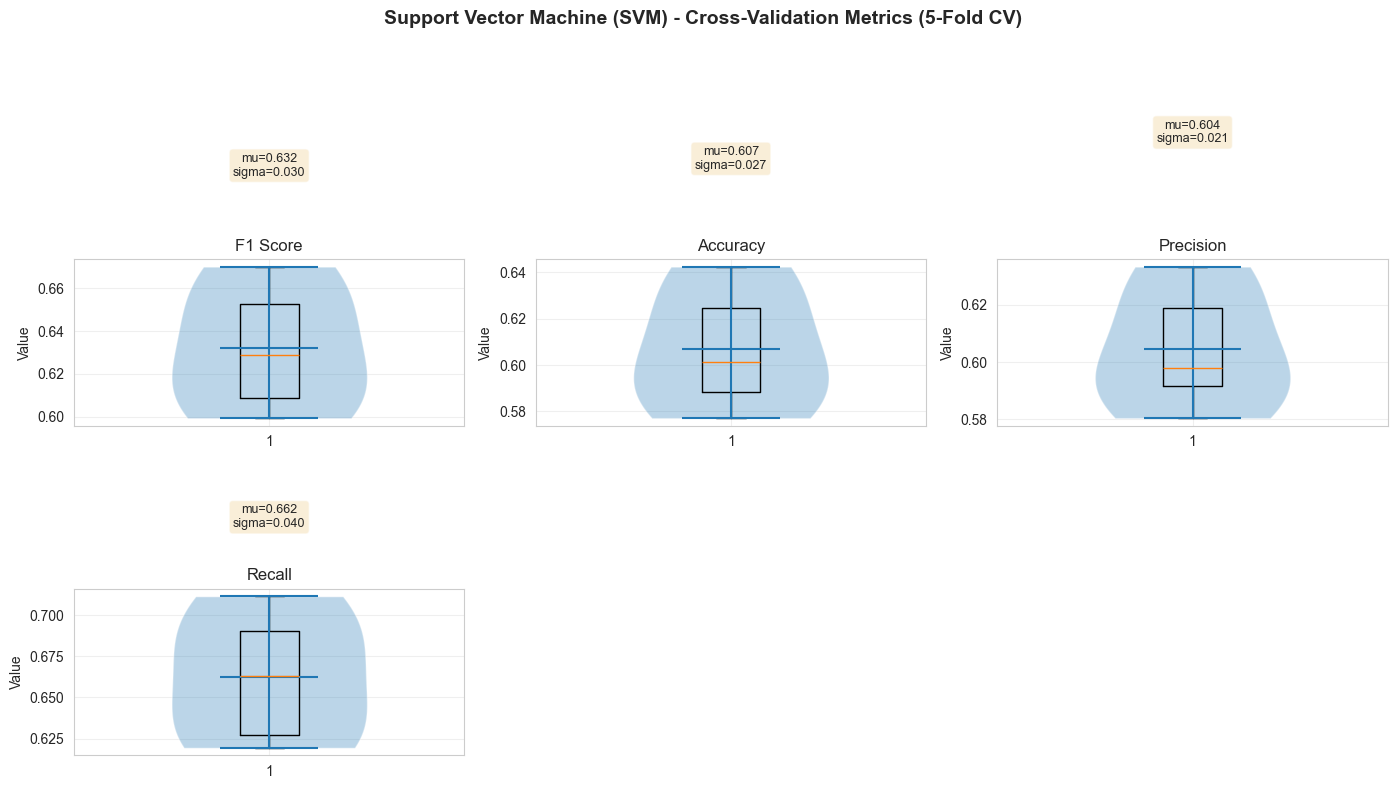

In [11]:
# Plot CV metrics comparison
if metrics and plot_cv_comparison:
    fig = plot_cv_comparison(metrics, model_name)
    plt.show()
else:
    print("[WARN] Cannot generate CV comparison - metrics or function unavailable")


### Confusion Matrices

Display confusion matrices for each cross-validation fold to visualize classification performance.

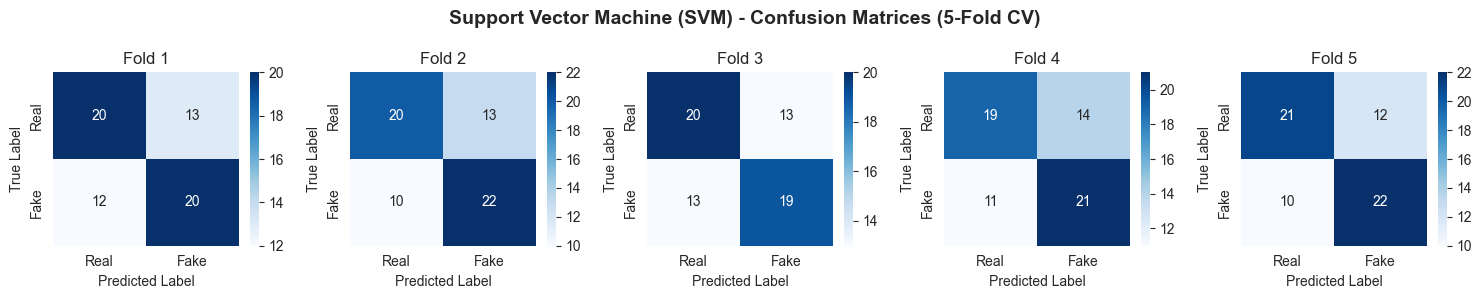

In [12]:
# Plot confusion matrices
if metrics and plot_confusion_matrices:
    fig = plot_confusion_matrices(
        metrics, model_name, model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
    plt.show()
else:
    print("[WARN] Cannot generate confusion matrices - metrics or function unavailable")


### ROC Curves

Display Receiver Operating Characteristic (ROC) curves from pre-generated PNG files or show a warning if unavailable.

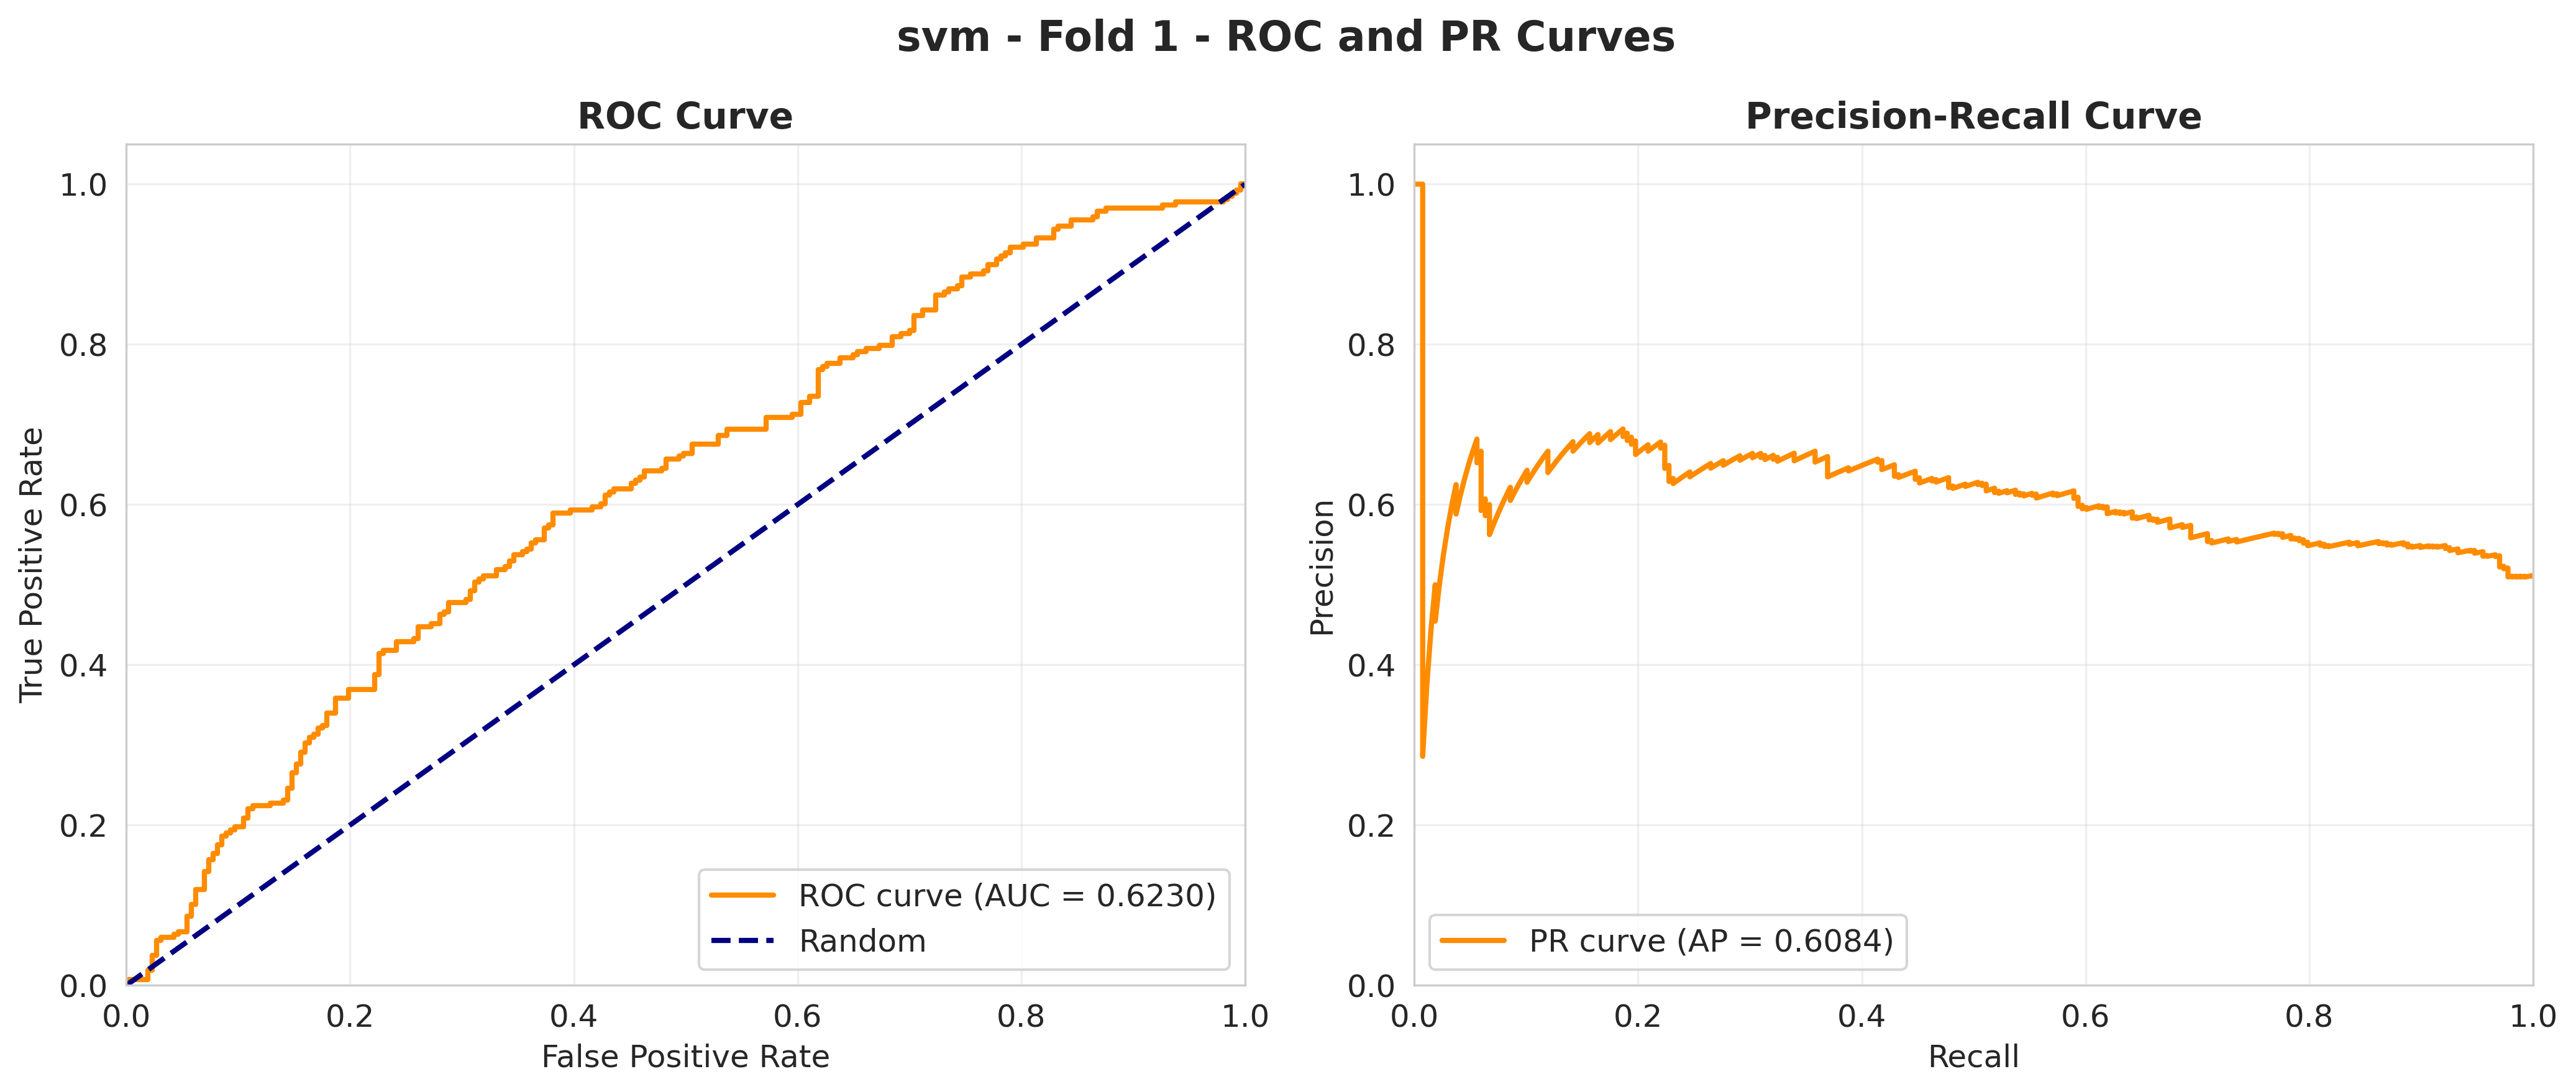

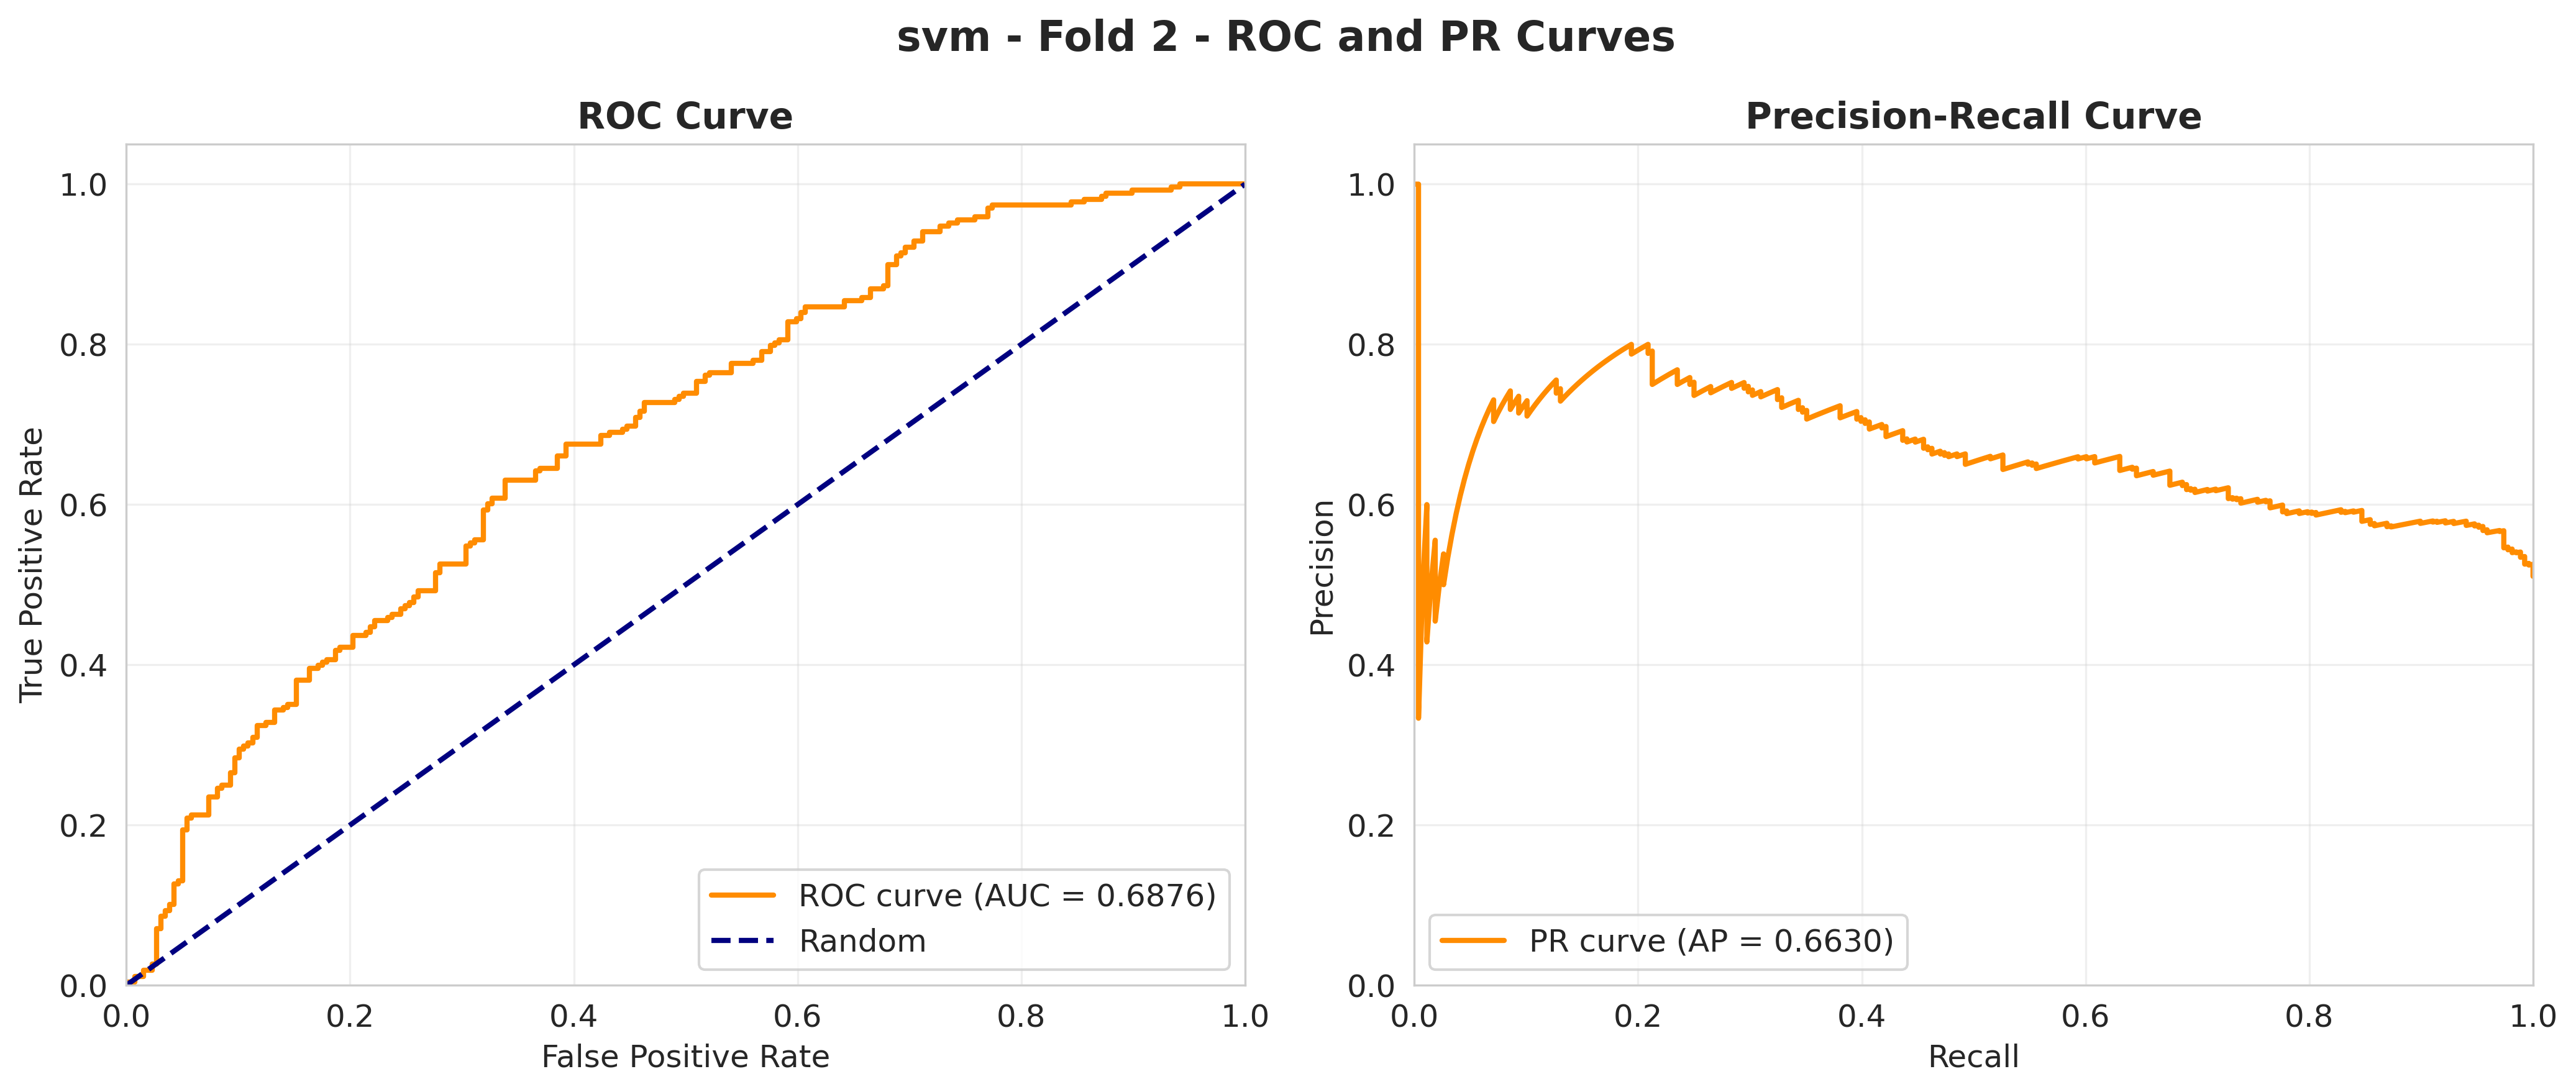

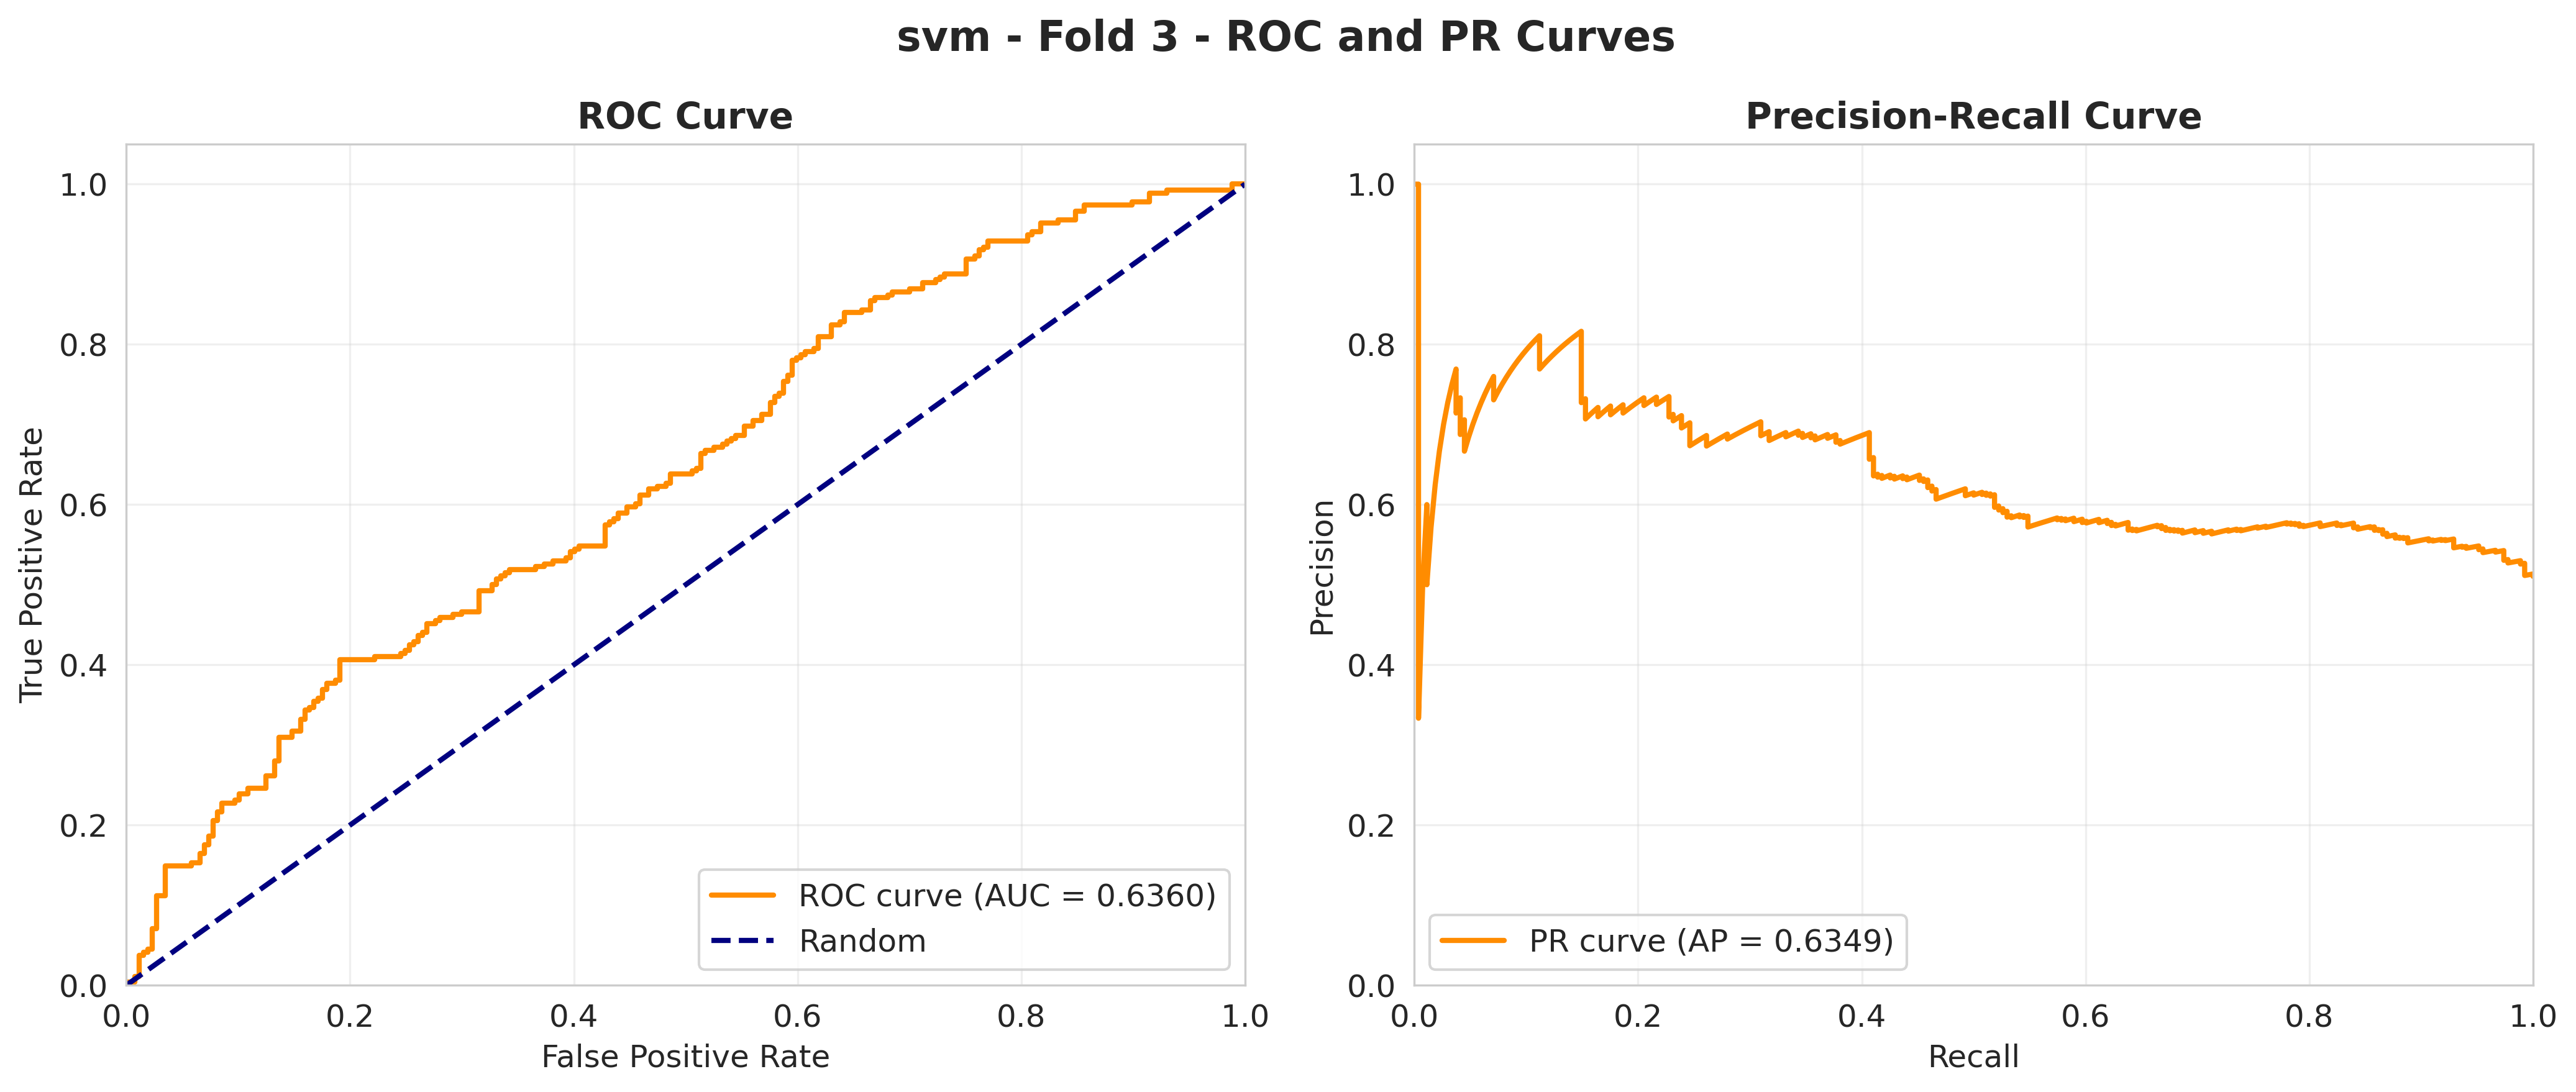

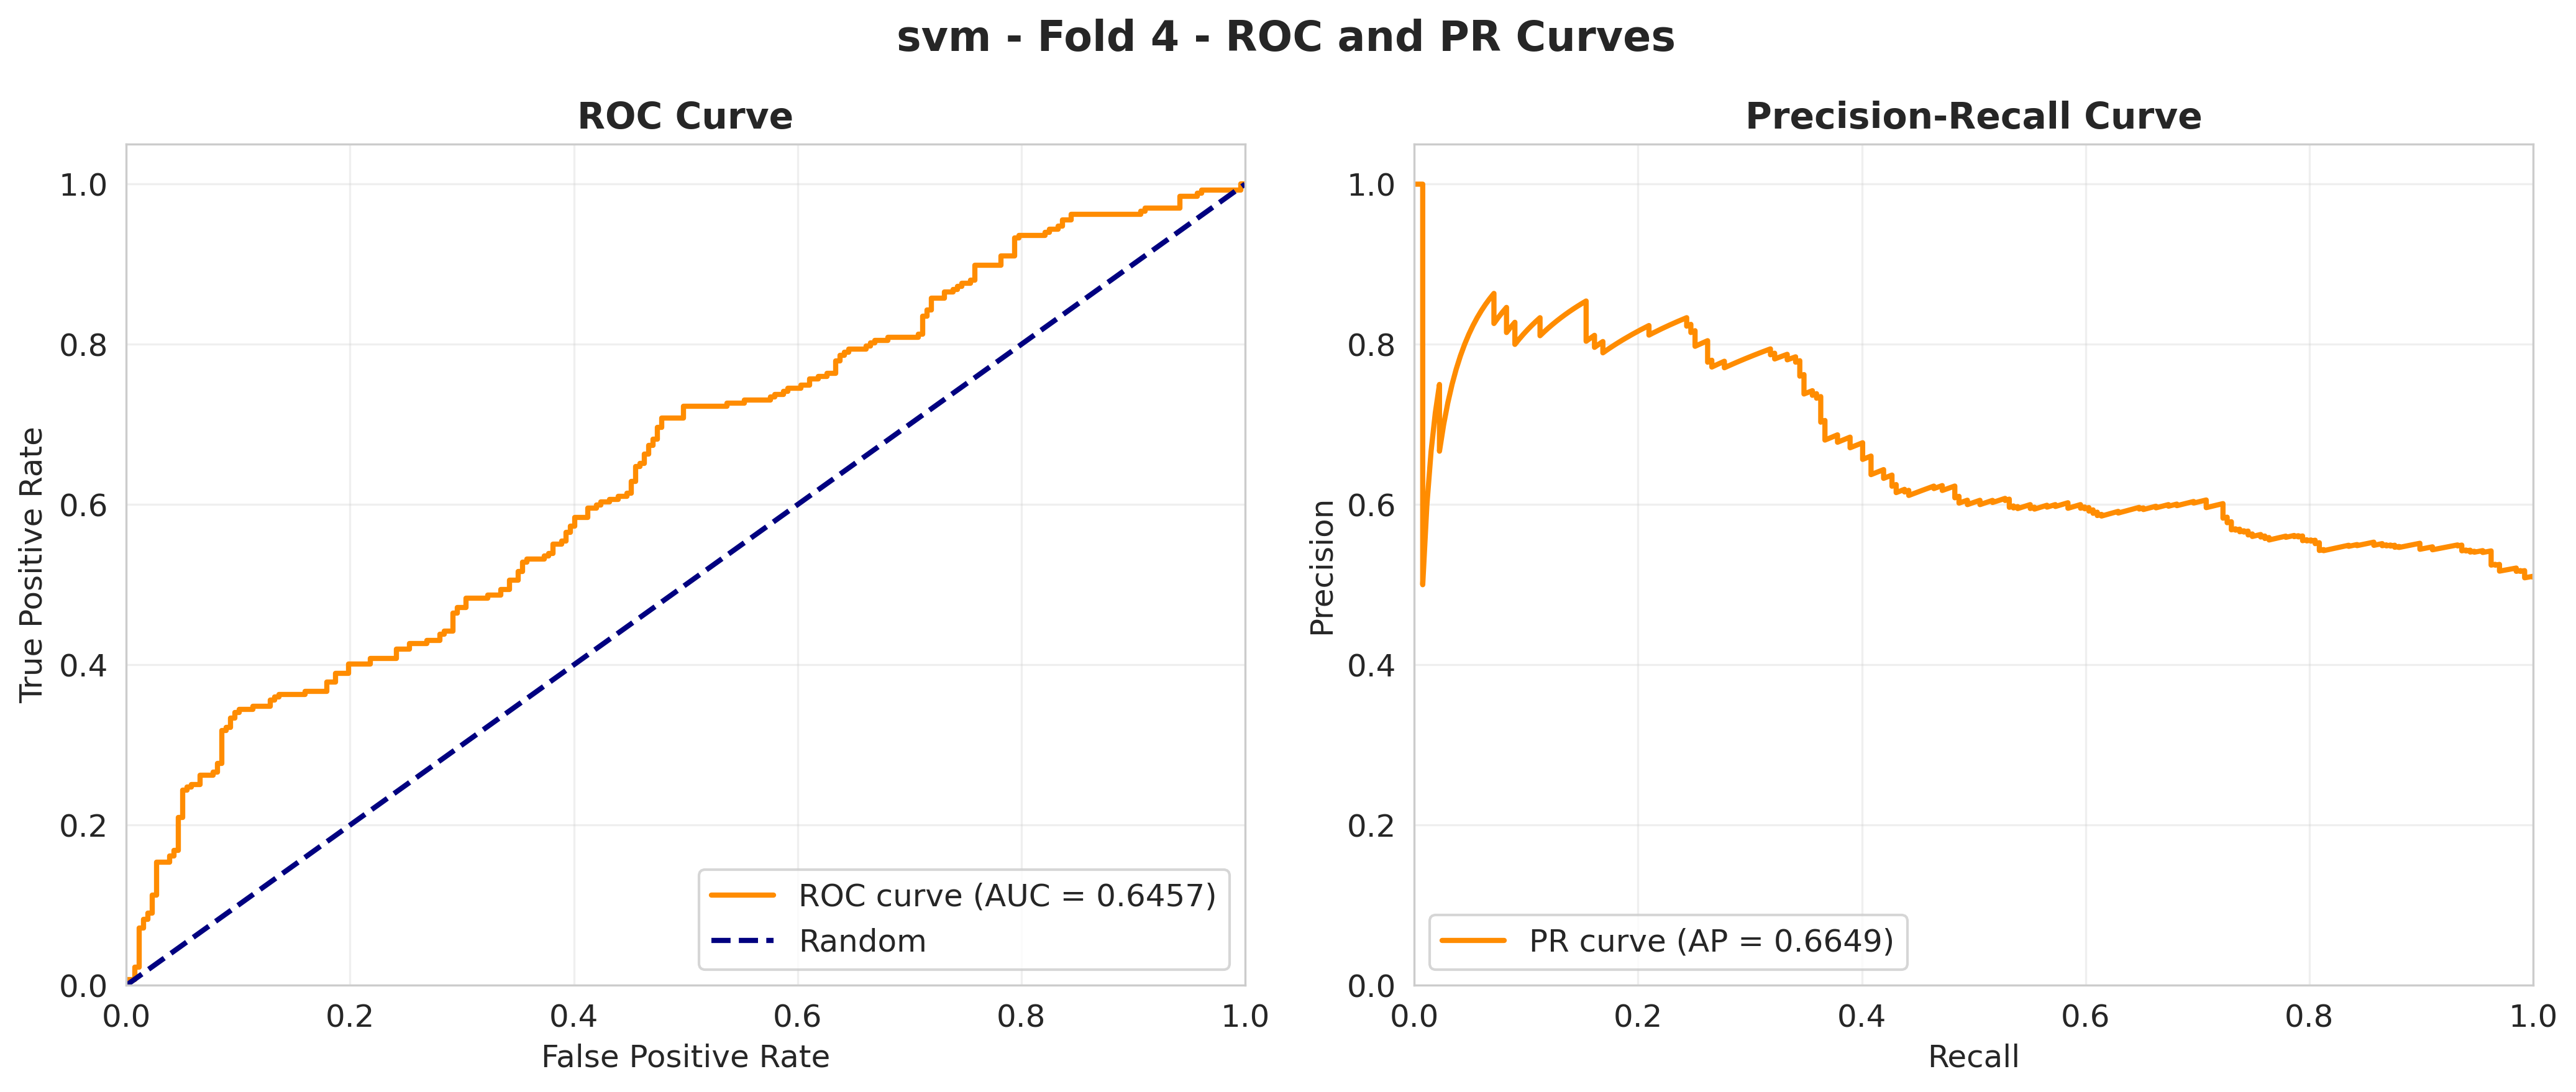

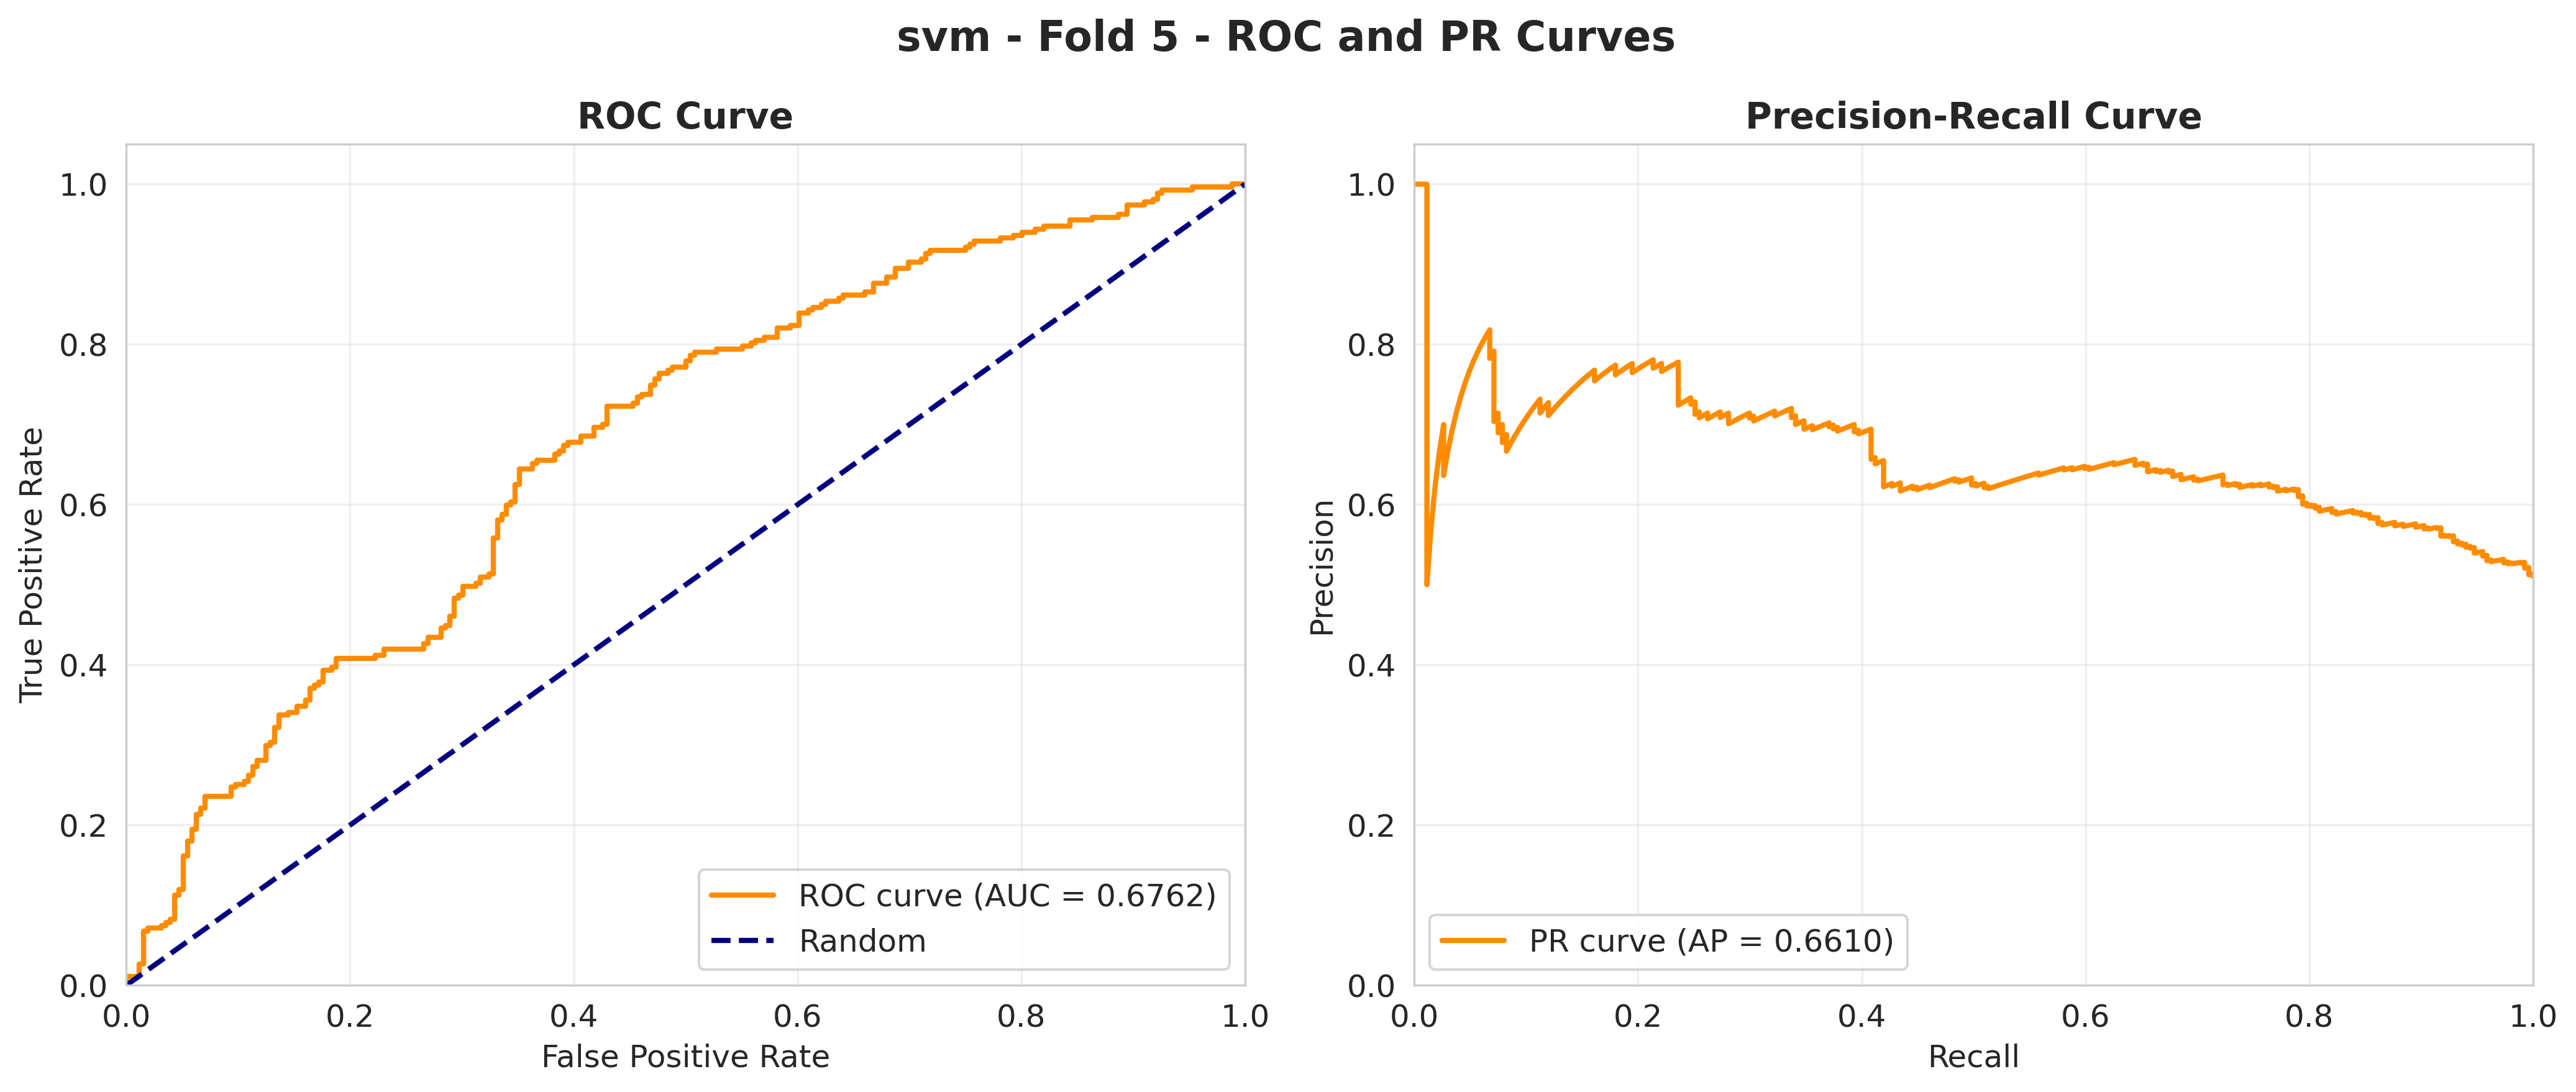

In [13]:
# Display ROC curves
if plot_roc_curves_comprehensive:
    plot_roc_curves_comprehensive(
        metrics, model_name, model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
else:
    print("[WARN] Cannot display ROC curves - function unavailable")


### Precision-Recall Curves

Display Precision-Recall (PR) curves from pre-generated PNG files or show a warning if unavailable.

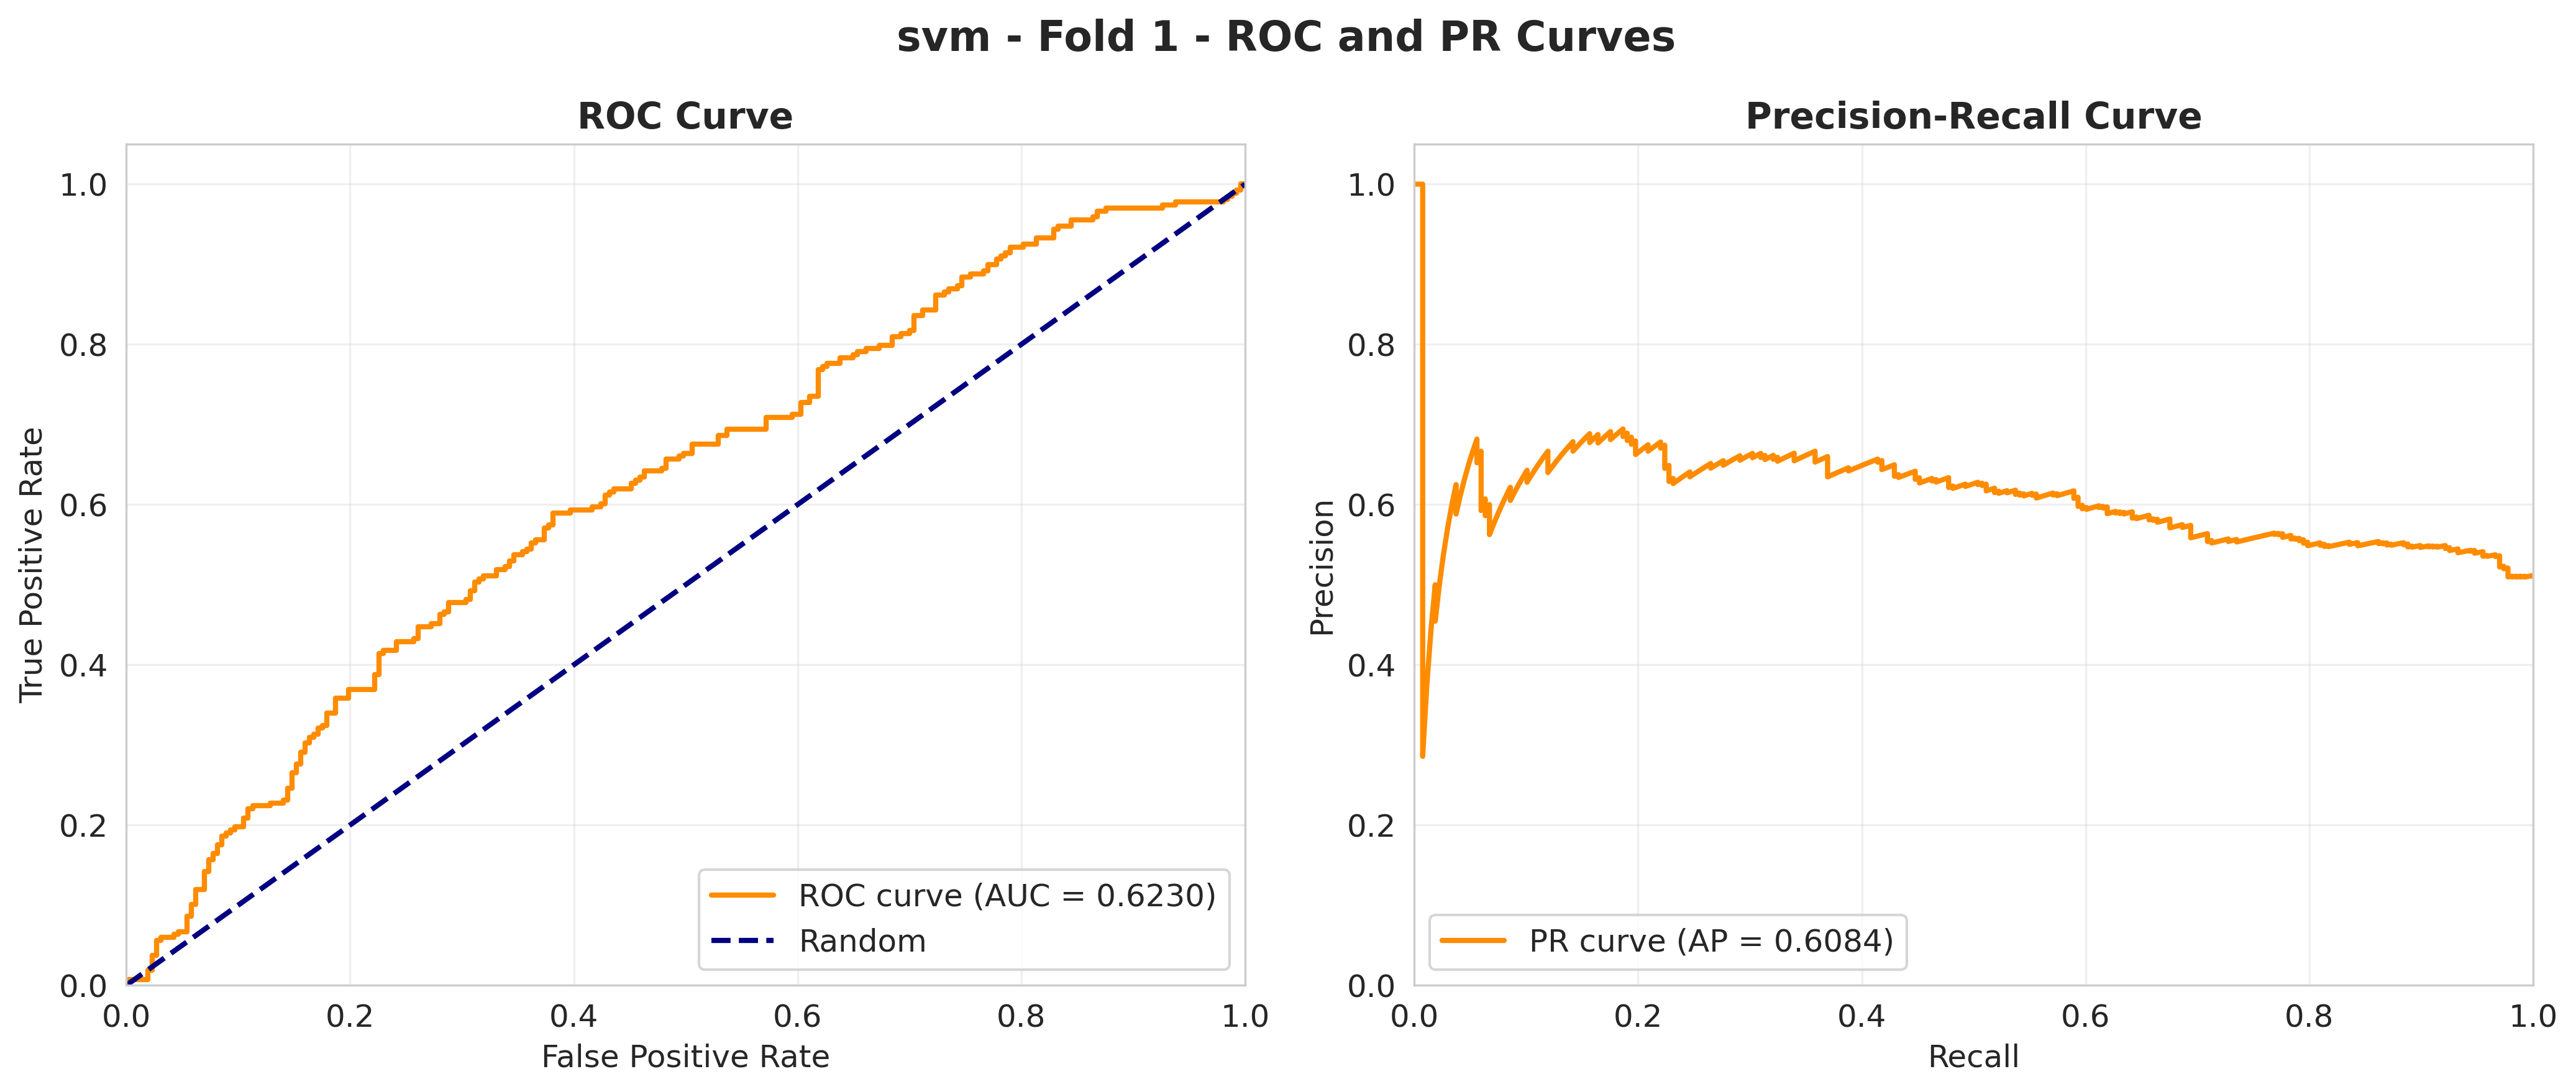

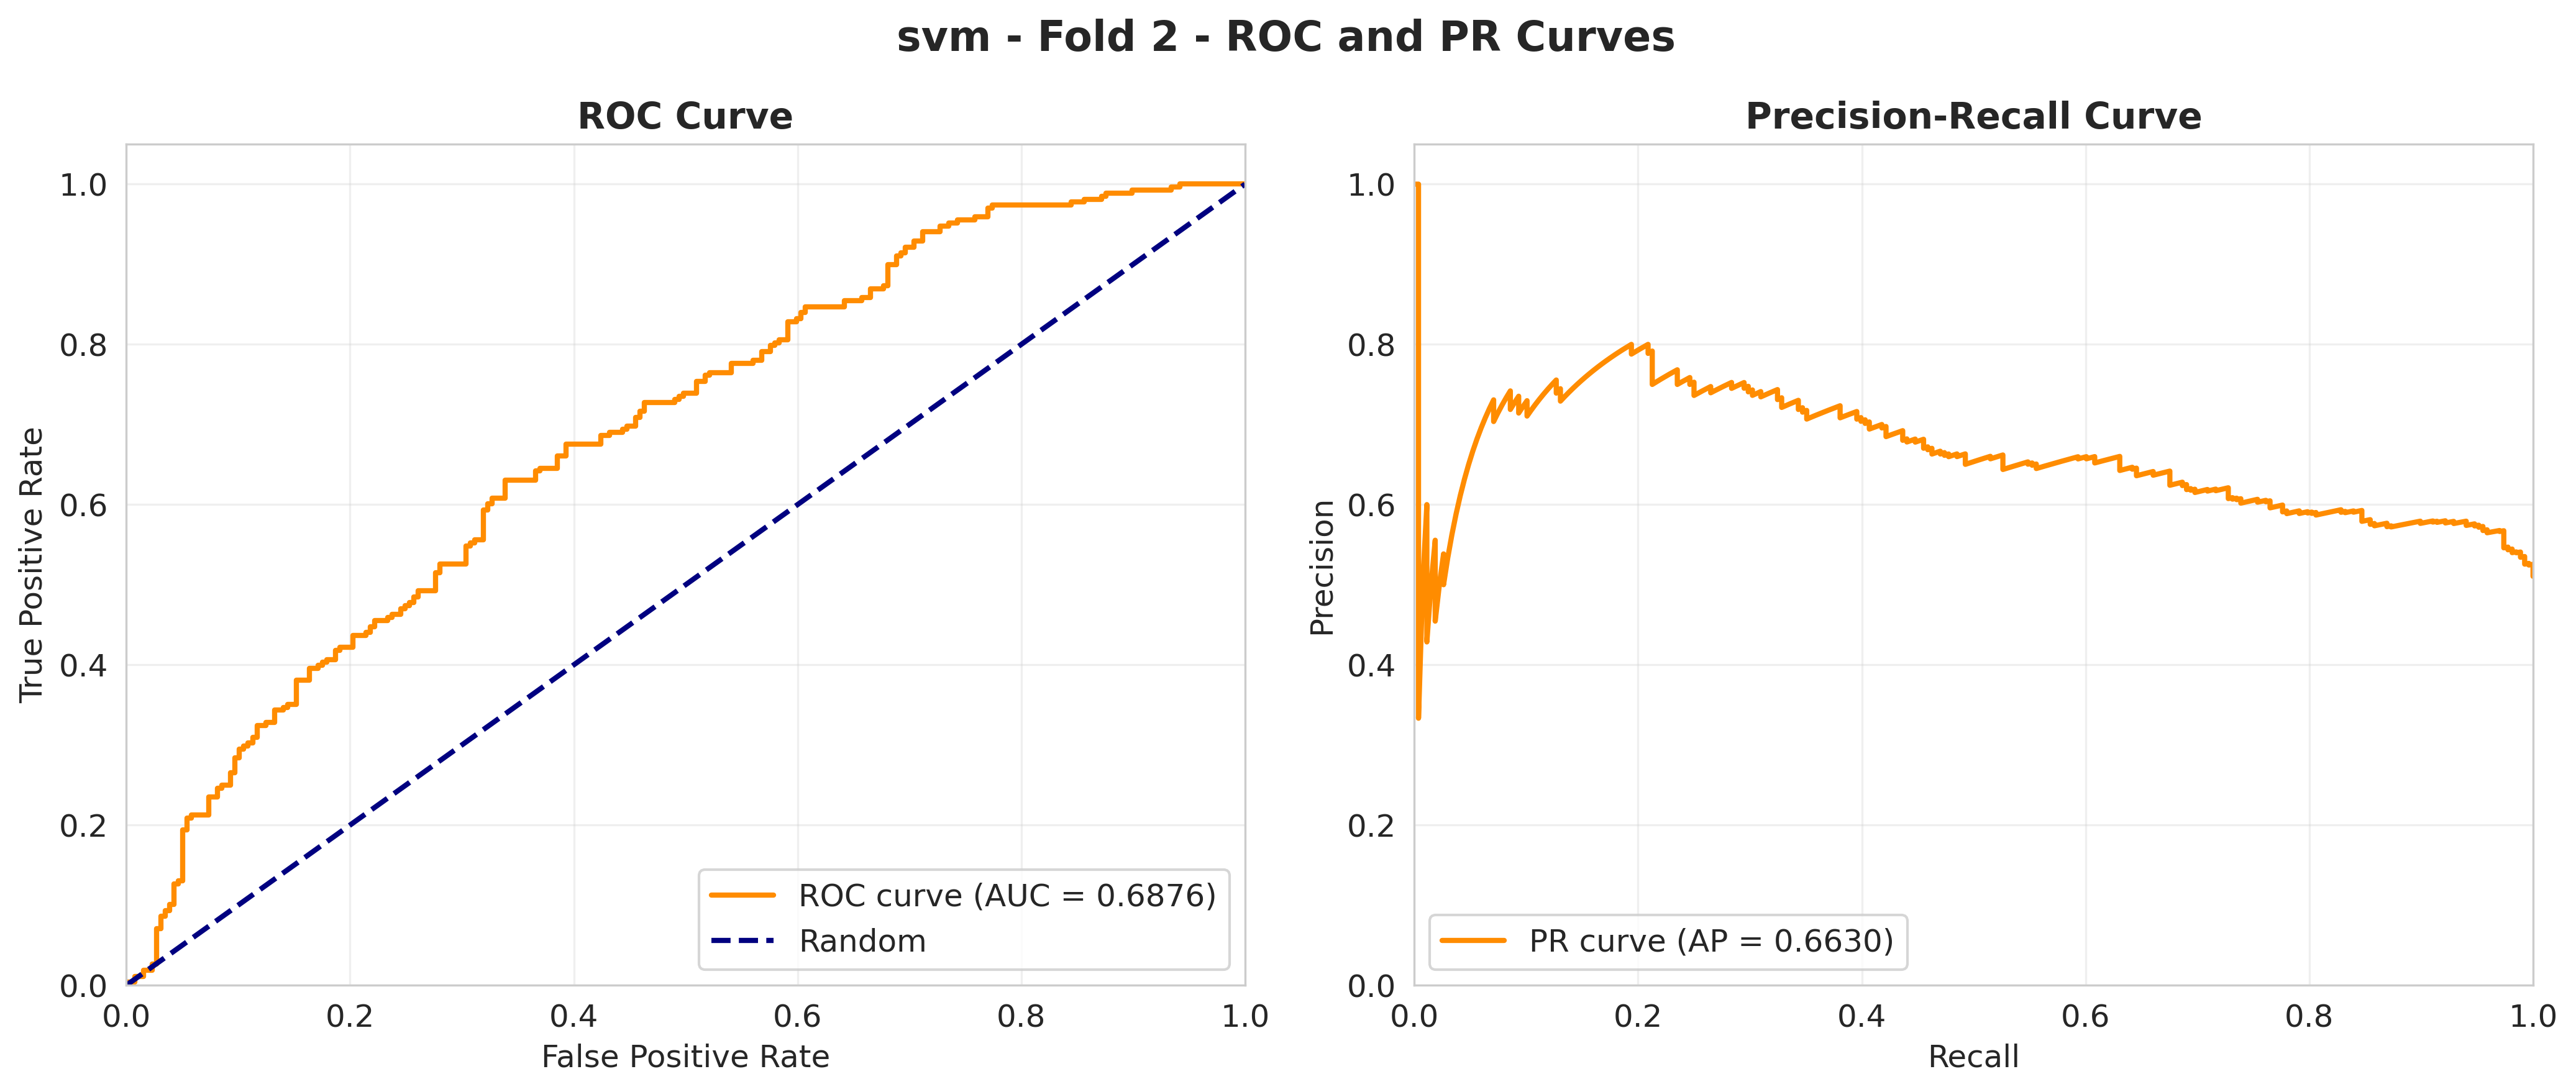

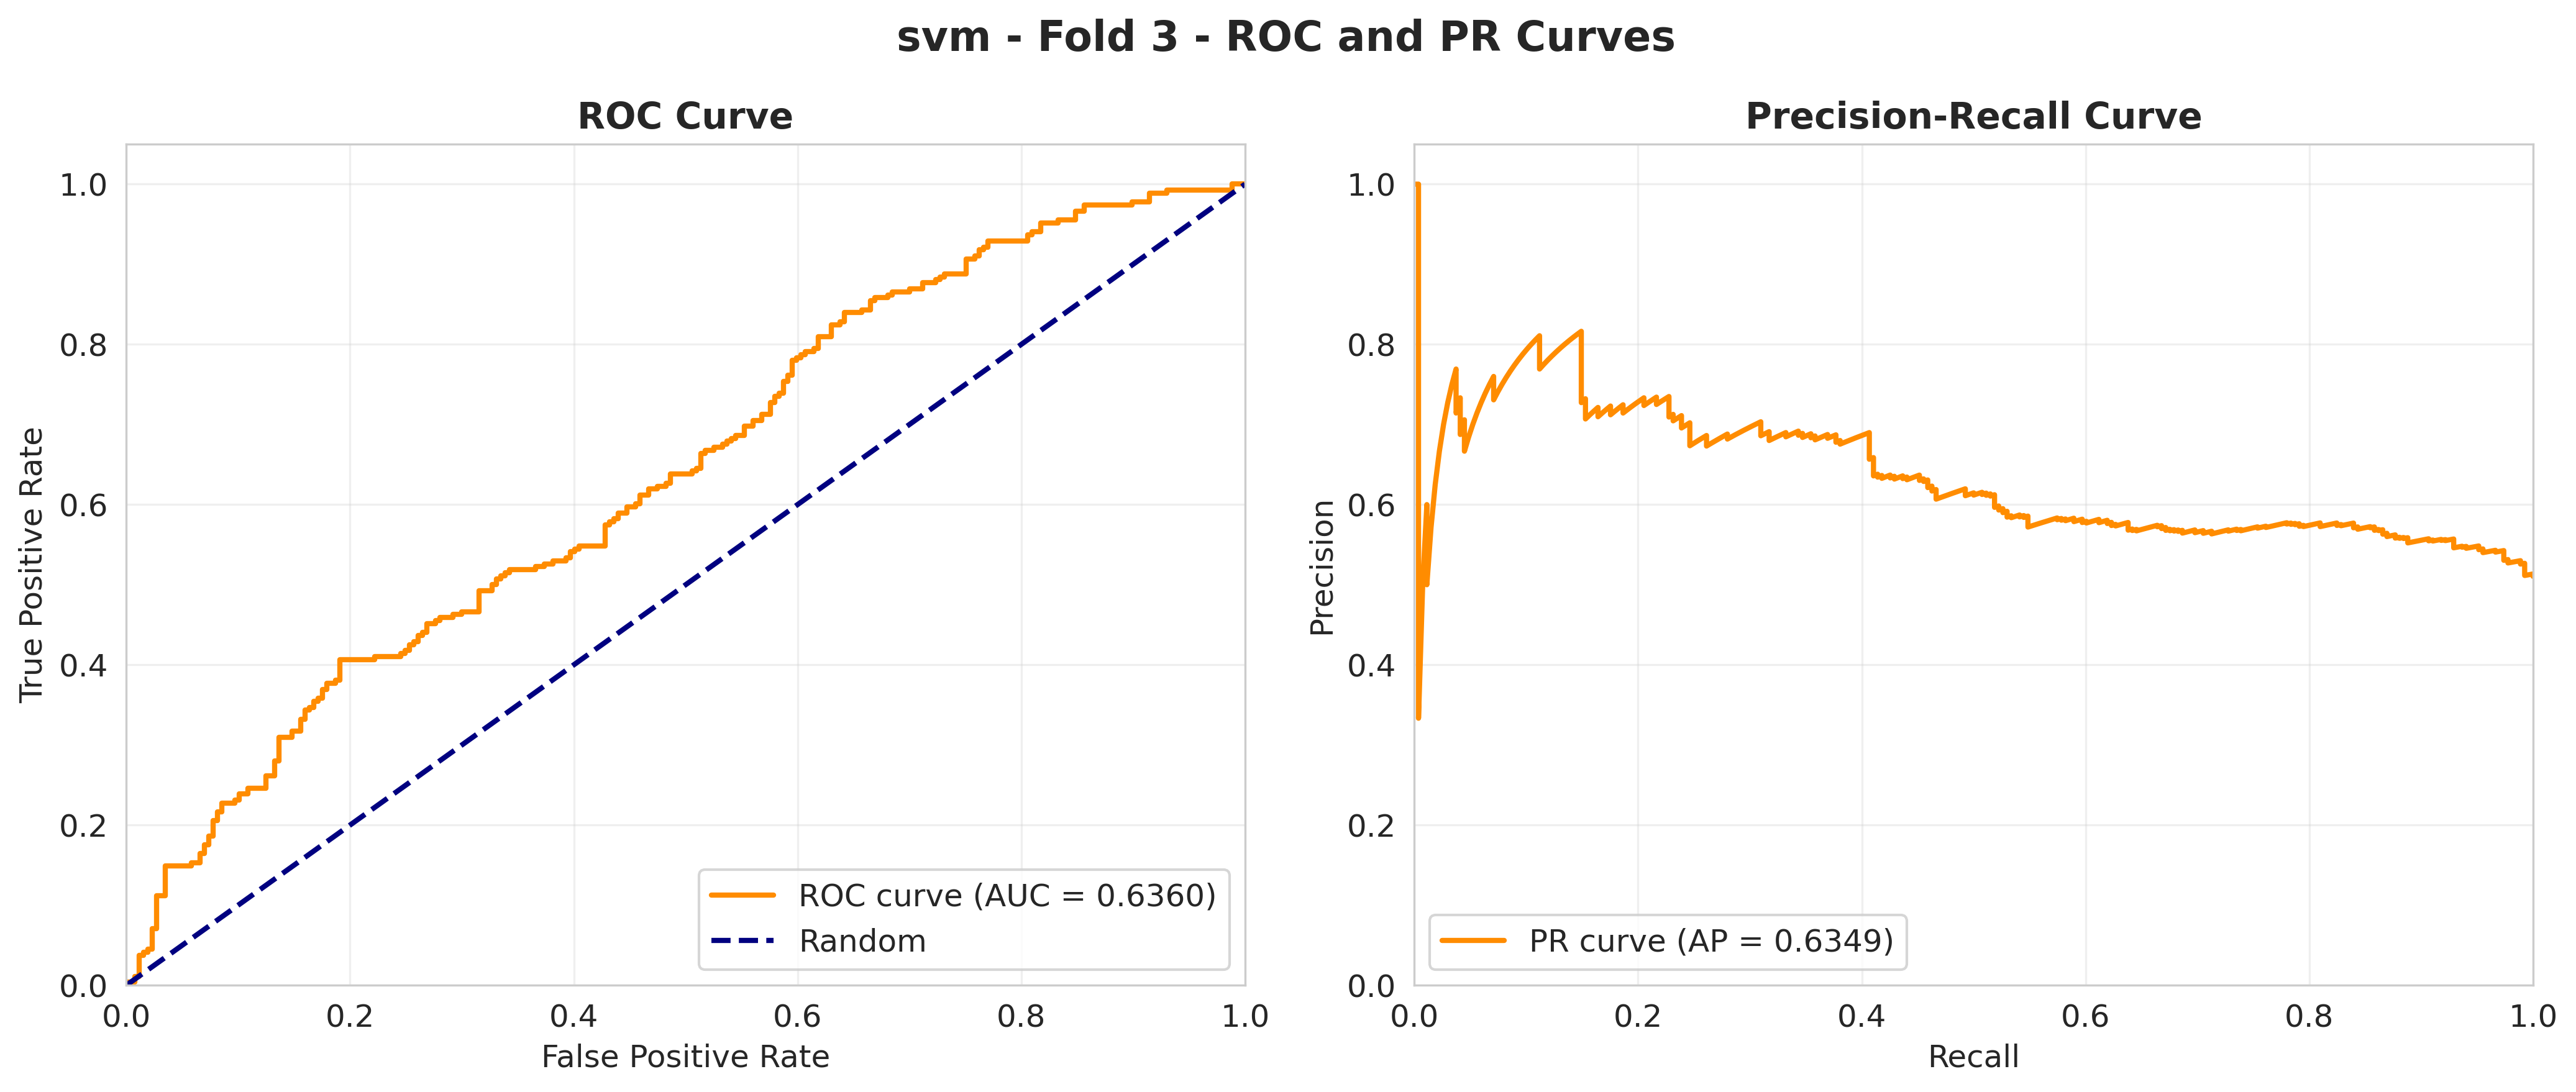

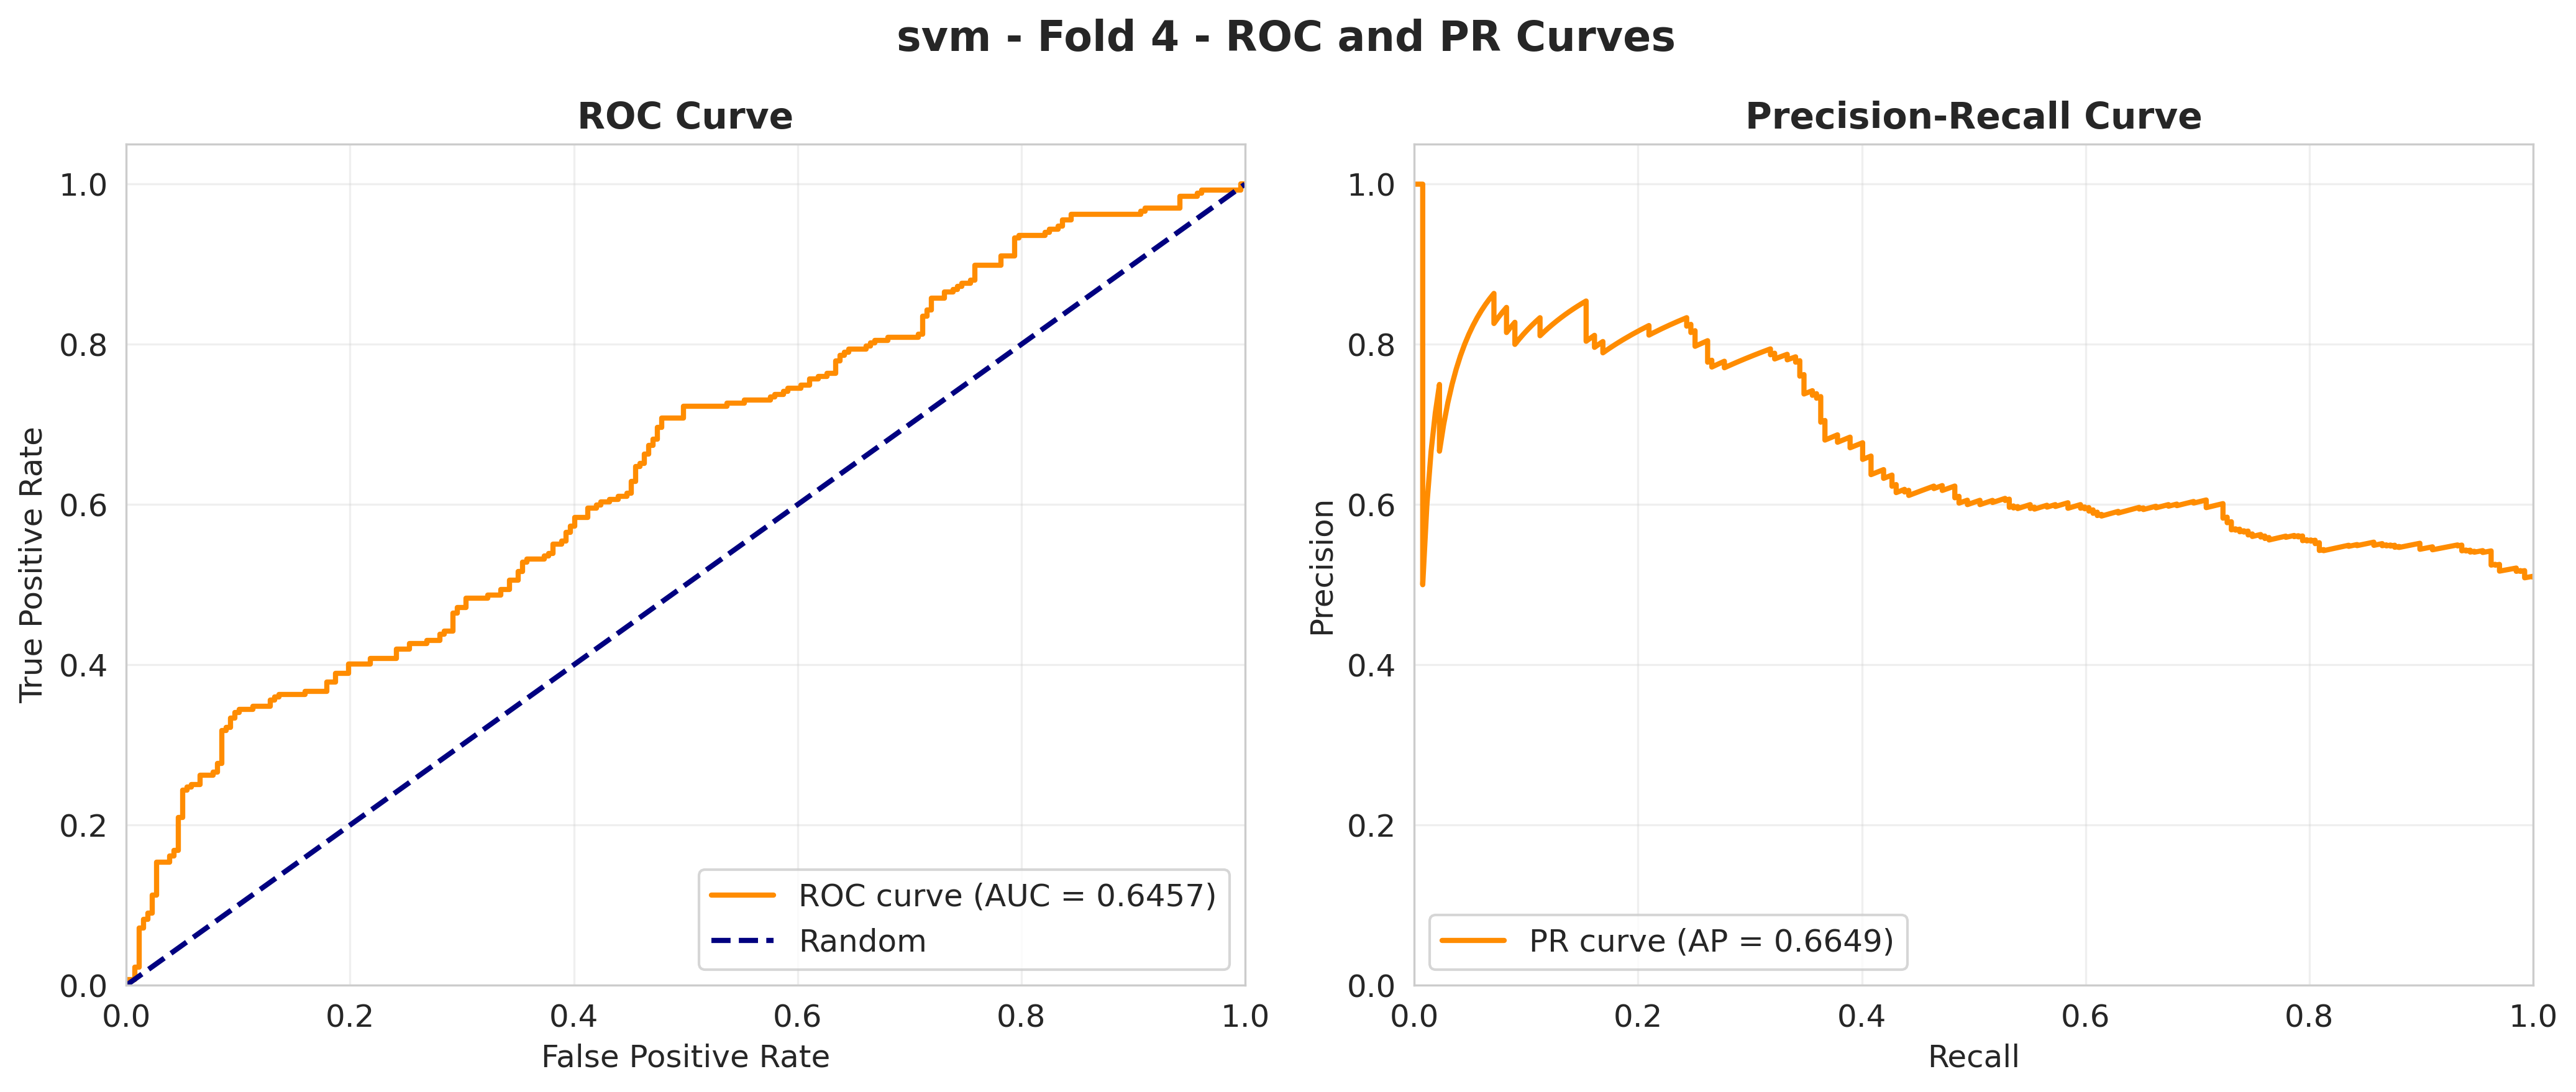

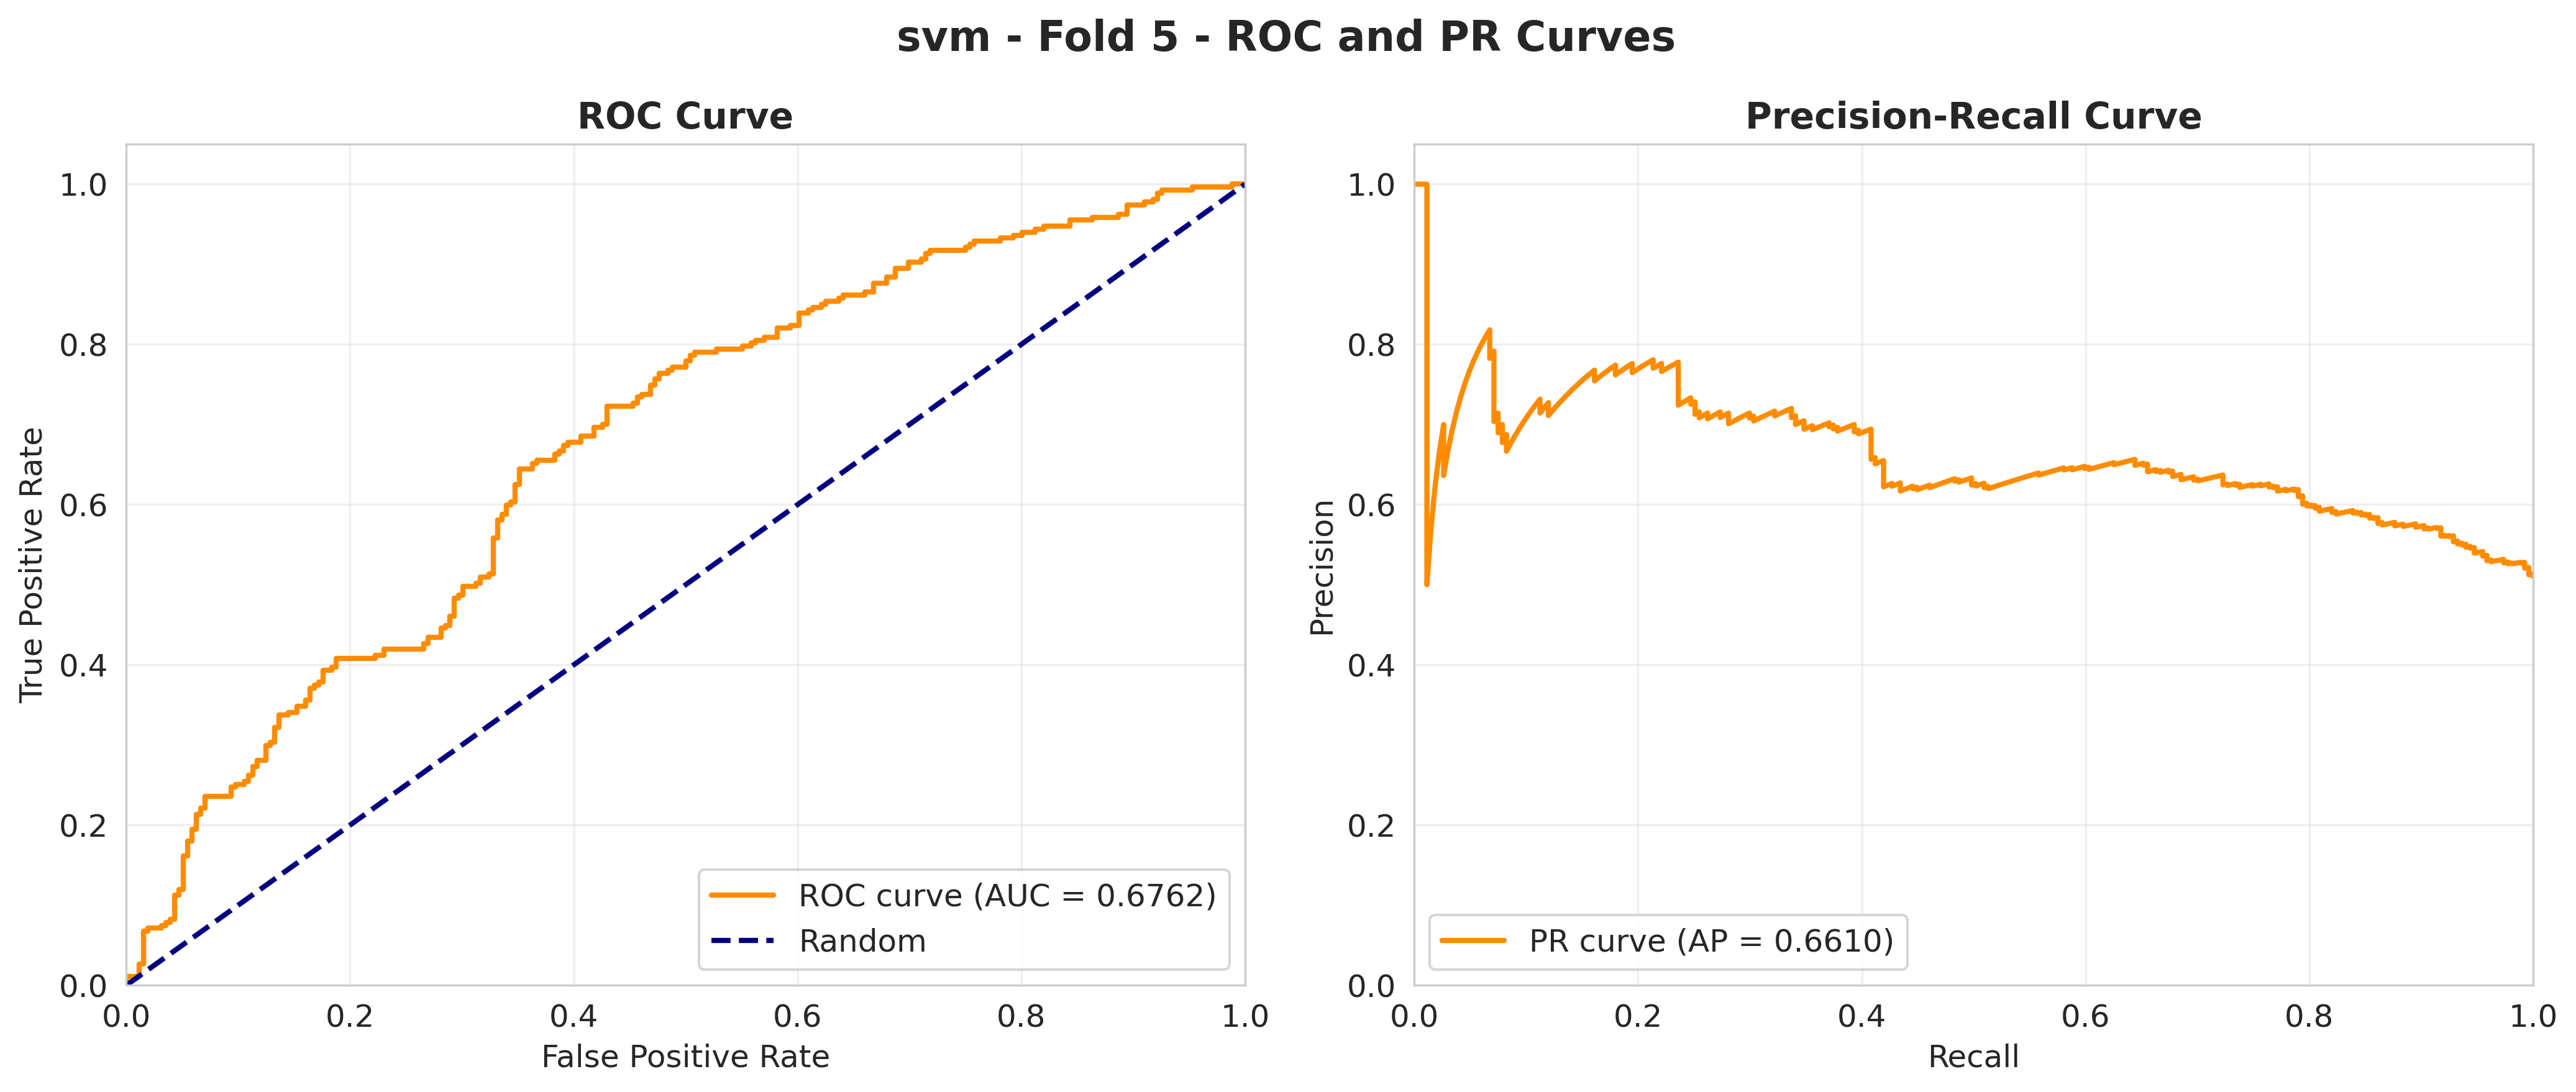

In [14]:
# Display PR curves
if plot_pr_curves_comprehensive:
    plot_pr_curves_comprehensive(
        metrics, model_name, model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
else:
    print("[WARN] Cannot display PR curves - function unavailable")


### Training Curves

Plot training and validation metrics from metrics.jsonl files.

**Note**: SVM logs final validation metrics. Training curves will show validation metrics after retraining.

In [15]:
# Plot training curves from metrics.jsonl
if plot_training_curves:
    model_data_path = get_model_data_path(
        model_id, PROJECT_ROOT, MODEL_TYPE_MAPPING
    )
    
    curves_found = False
    # Dynamically find all available folds
    if model_data_path and model_data_path.exists():
        fold_dirs = sorted([d for d in model_data_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
        for fold_dir in fold_dirs:
            metrics_file = fold_dir / "metrics.jsonl"
        
            if metrics_file.exists():
                fig = plot_training_curves(metrics_file, model_name)
                if fig:
                    plt.show()
                    curves_found = True
                    break
    
    if not curves_found:
        print("[WARN] No training curves data found")

    # Fallback: Try extracting from log files
    if not curves_found and get_latest_job_ids:
        from notebook_utils import extract_training_curves_from_log
        latest_job_ids = get_latest_job_ids(PROJECT_ROOT)
        job_id = latest_job_ids.get(model_id, "unknown")
        if job_id != "unknown":
            log_file = PROJECT_ROOT / "logs" / "stage5" / f"stage5{model_id[-1]}_{job_id}.log"
            if log_file.exists():
                log_curves = extract_training_curves_from_log(log_file, model_id)
                if log_curves and log_curves.get("val", {}).get("epoch"):
                    print(f"[INFO] Extracted validation metrics from log file (fold-wise)")
                    # Plot the extracted curves
                    from notebook_utils import plot_training_curves_from_history
                    if plot_training_curves_from_history:
                        fig = plot_training_curves_from_history(log_curves, model_name)
                        if fig:
                            plt.show()
                            curves_found = True
                    # Note: Logs only have fold-wise validation metrics, not per-epoch training
else:
    print("[WARN] Cannot display training curves - function unavailable")


### Validation Metrics Across Folds

For baseline models (sklearn), plot validation metrics across CV folds.
Since these models don't have training epochs, this shows how validation
performance varies across different data splits.

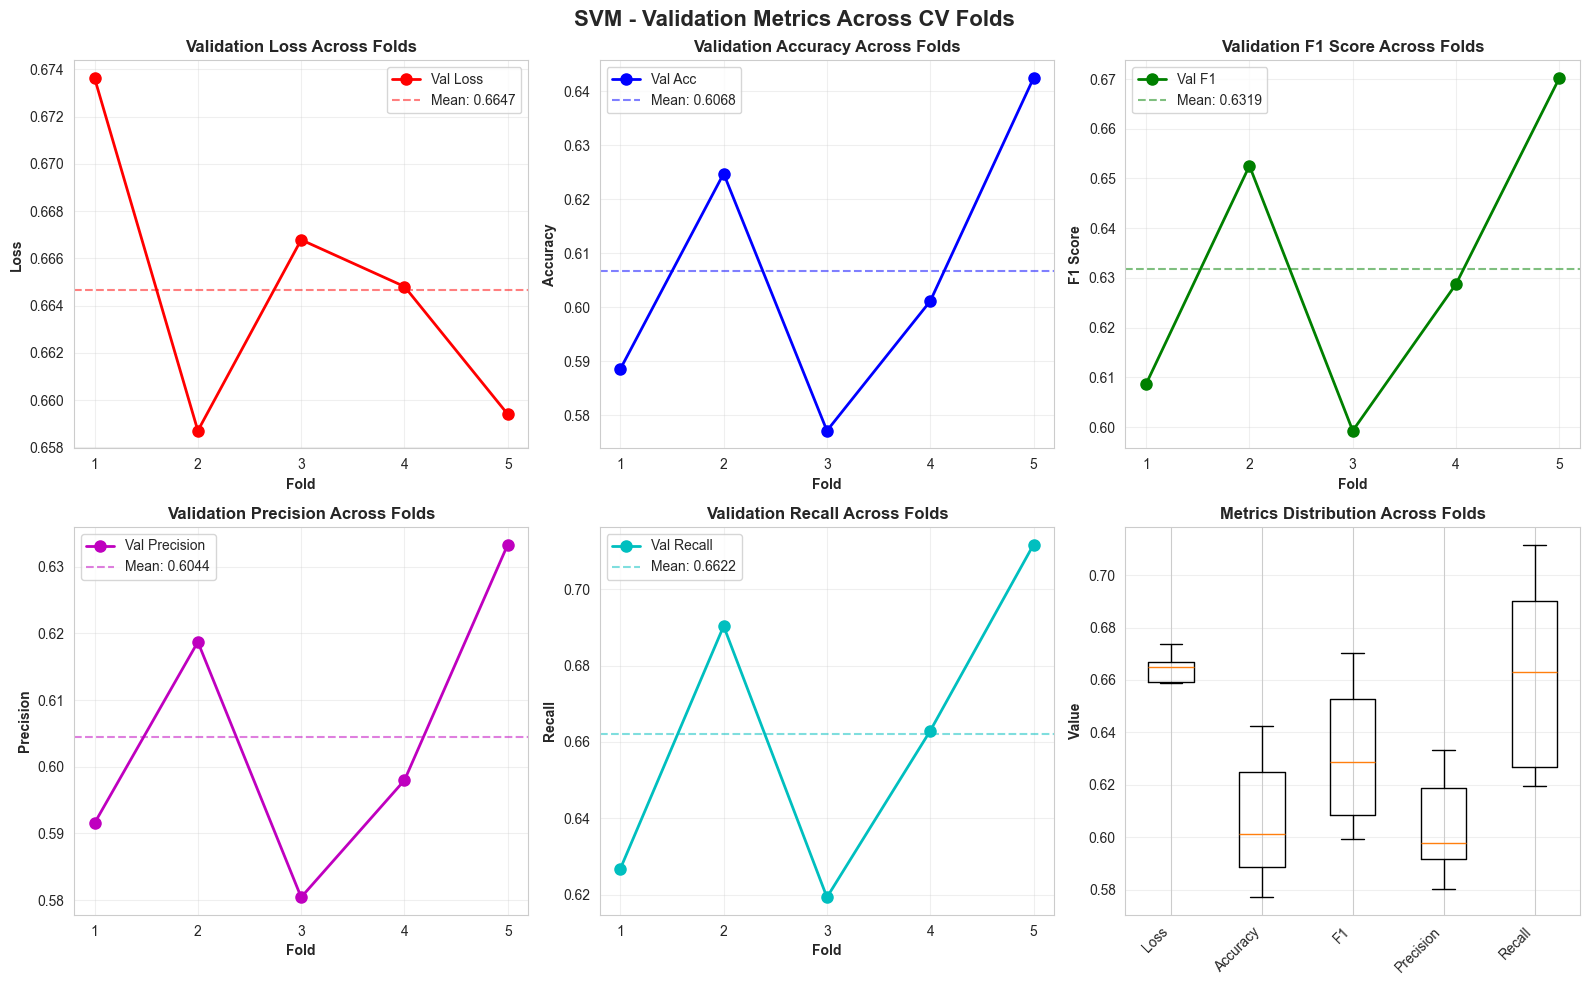

In [16]:
# Plot validation metrics across CV folds for baseline models
try:
    if metrics:
        fig = plot_validation_metrics_across_folds(metrics, model_name)
    if fig:
        plt.show()
    else:
        print("[WARN] Could not generate validation metrics plot")
except Exception as e:
    print(f"[WARN] Error in try block: {e}")
if not metrics:
    print("[WARN] No metrics available for plotting")
else:
    print("[WARN] Cannot display validation metrics - function unavailable")
